In [142]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import pickle
from scipy.interpolate import griddata, interp1d
from scipy.stats import gaussian_kde, multivariate_normal

# Testing

## Setup

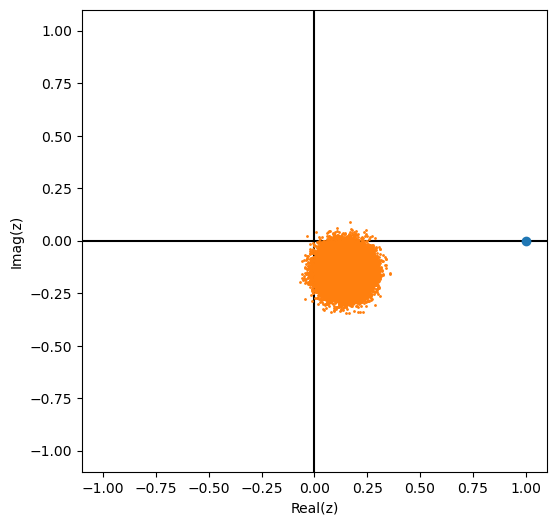

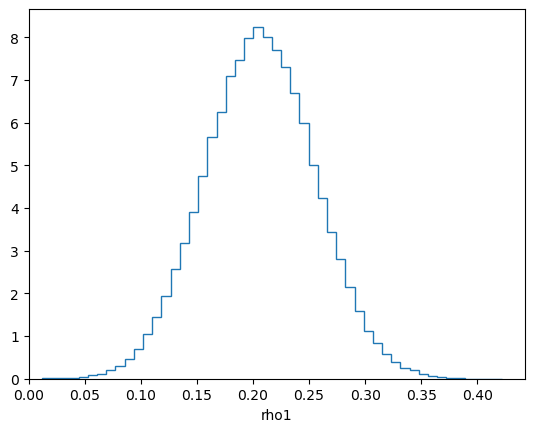

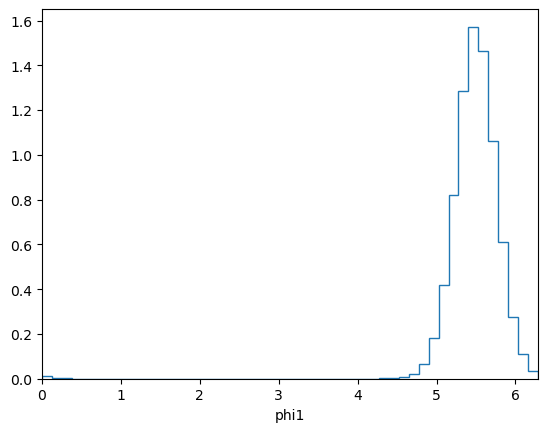

In [167]:
# SNRs and number of samples
rho_0 = 20
rho_1 = 4
rho_n1 = 1
z_0 = rho_0 + 1j*0
z_1 = np.sqrt(rho_1**2/2)-1j*np.sqrt(rho_1**2/2)
z_n1 = -np.sqrt(rho_n1**2/2)-1j*np.sqrt(rho_n1**2/2)
n = 100000

# Generate samples
samples_real, samples_imag = np.random.normal(np.real(z_1), 1, n), np.random.normal(np.imag(z_1), 1, n)
samples = samples_real + 1j*samples_imag
samples_real_n1, samples_imag_n1 = np.random.normal(np.real(z_n1), 1, n), np.random.normal(np.imag(z_n1), 1, n)
samples_n1 = samples_real_n1 + 1j*samples_imag_n1

# Plot samples in complex space
plt.figure(figsize=(6,6))
plt.scatter(np.real(z_0)/np.abs(z_0), np.imag(z_0)/np.abs(z_0))
plt.scatter(samples_real/np.abs(z_0), samples_imag/np.abs(z_0), s=1)
# plt.scatter(samples_real_n1, samples_imag_n1, s=1)
max_point = np.max([np.max([samples_real/np.abs(z_0), samples_imag/np.abs(z_0)]), np.real(z_0)/np.abs(z_0), np.imag(z_0)/np.abs(z_0)])*1.1
plt.xlim(-max_point,max_point)
plt.ylim(-max_point,max_point)
plt.axvline(0, c='k', zorder=0)
plt.axhline(0, c='k', zorder=0)
plt.xlabel('Real(z)')
plt.ylabel('Imag(z)')
plt.show()

# Plot amplitude of samples (SNR)
plt.hist(np.abs(samples)/np.abs(z_0), bins=50, histtype='step', density=True)
plt.xlim(0,)
plt.xlabel('rho1')
plt.show()

# Plot phase of samples
plt.hist(np.angle(samples)%(2*np.pi), bins=50, histtype='step', range=(0,2*np.pi), density=True)
plt.xlim(0,2*np.pi)
plt.xlabel('phi1')
plt.show()

## Prior + rejection sampling

In [3]:
with open(os.path.join('grid_data_4d', 'dataslot_0', 'all_matches'), 'rb') as fp:
    grid_data_0 = pickle.load(fp)

In [131]:
# Get sparse mapping points
e_vals = grid_data_0['metadata']['degen_params']['ecc10']
sparse_e = np.tile(np.repeat(e_vals, len(MA_vals)),3)
MA_merger = (grid_data_0['h1_phase']-grid_data_0['h0_phase']).flatten()%(2*np.pi)
sparse_MA = np.concatenate((MA_merger-2*np.pi, MA_merger, MA_merger+2*np.pi))
sparse_SNR = np.tile(grid_data_0['h1_h0'].flatten(), 3)

# Get dense mapping points
map_len = 201
map_MA = np.repeat(np.linspace(0, 2*np.pi, map_len), map_len)
map_e = np.tile(np.linspace(np.min(e_vals), np.max(e_vals), map_len), map_len)
map_SNR = griddata((sparse_e, sparse_MA), sparse_SNR, (map_e, map_MA), method='linear')

In [136]:
# Draw prior
n = 10**5
ecc_prior = np.random.rand(n)*(np.max(e_vals)-np.min(e_vals)) + np.min(e_vals)
MA_prior= np.random.rand(n)*2*np.pi

In [137]:
# Put prior through inverse map
prior_rho_frac = griddata((map_e, map_MA), map_SNR, (ecc_prior, MA_prior), method='linear')
prior_samples = prior_rho_frac*np.e**(1j*MA_prior)

Text(0, 0.5, 'Imag(z_prior)')

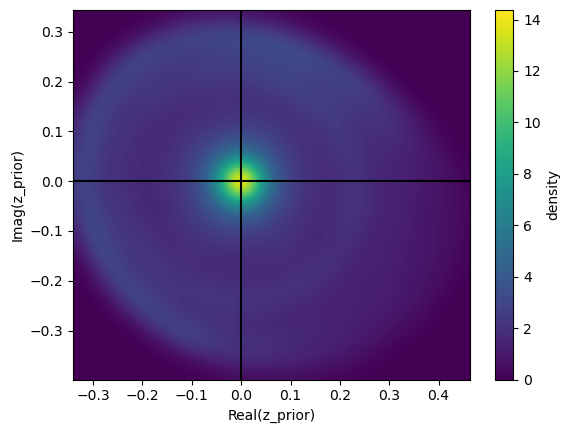

In [138]:
# Compute prior kde at points on 2d grid
kde_samples = np.array([np.real(prior_samples), np.imag(prior_samples)])
kernel = gaussian_kde(kde_samples)
kde_x, kde_y = np.mgrid[np.min(np.real(prior_samples)):np.max(np.real(prior_samples)):51j, np.min(np.imag(prior_samples)):np.max(np.imag(prior_samples)):51j]
kde_z = kernel(np.vstack([kde_x.flatten(), kde_y.flatten()])).reshape(kde_x.shape)

# Plot prior kde
x_coords = kde_x[:,0]
y_coords = kde_y[0]
dx = (x_coords[1]-x_coords[0])/2.
dy = (y_coords[1]-y_coords[0])/2.
extent = [x_coords[0]-dx, x_coords[-1]+dx, y_coords[0]-dy, y_coords[-1]+dy]
cm = plt.imshow(kde_z.T, interpolation='bicubic', cmap='viridis', extent=extent, origin='lower', aspect='auto')
plt.colorbar(cm, label='density')

# Plot formatting
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xlabel('Real(z_prior)')
plt.ylabel('Imag(z_prior)')

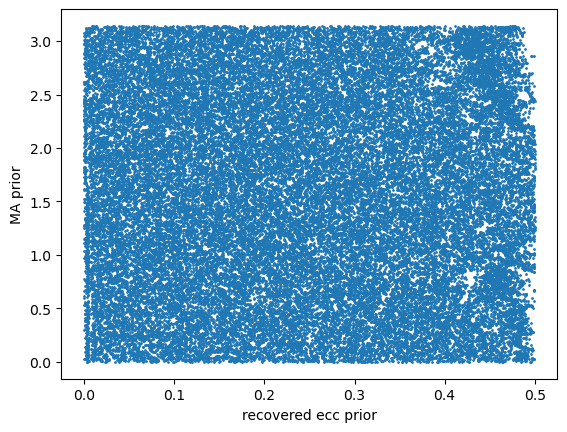

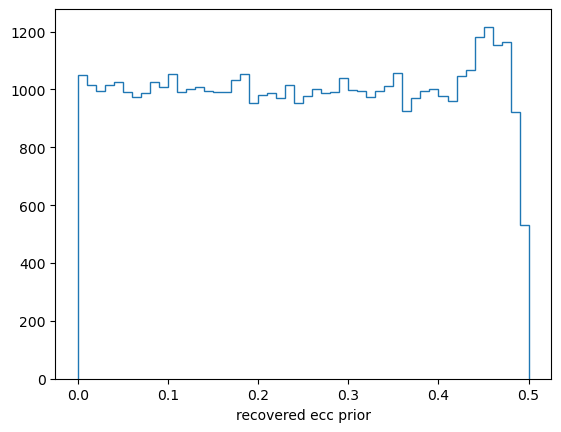

In [141]:
# Mapping back to ecc/MA space to check recover original flat priors
reverse_ecc_prior = griddata((map_SNR, map_MA), map_e, (np.abs(prior_samples), np.angle(prior_samples)), method='linear')

plt.scatter(reverse_ecc_prior, MA_prior, s=1)
plt.xlabel('recovered ecc prior')
plt.ylabel('MA prior')
plt.show()

plt.hist(reverse_ecc_prior, histtype='step', bins=50, range=(0,0.5))
plt.xlabel('recovered ecc prior')
plt.show()

In [173]:
rv.pdf([-0.2,0.2])

0.30927771775963586

2891 100000 0.02891


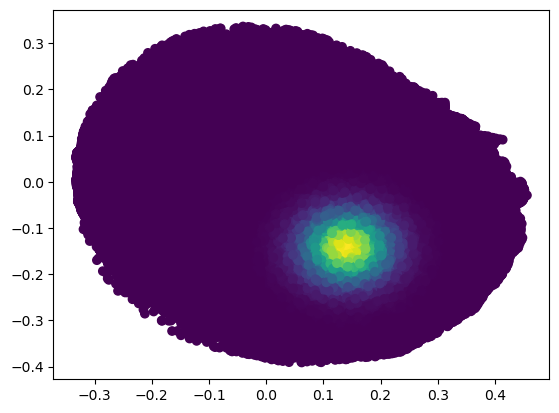

In [175]:
# Analytic 2d gaussian to model h1 SNR
rv = multivariate_normal(mean=[np.real(z_1), np.imag(z_1)], cov=[1,1])

# Get weights for each prior sample
weights = rv.pdf(np.array([np.real(prior_samples)*np.abs(z_0), np.imag(prior_samples)*np.abs(z_0)]).T)
weights /= np.max(weights)
plt.scatter(np.real(prior_samples), np.imag(prior_samples), c=weights, cmap='viridis')
likeL_samples = prior_samples[np.random.rand(len(weights))<=weights]

print(len(likeL_samples), len(prior_samples), len(likeL_samples)/len(prior_samples))
# plt.scatter(np.real(likeL_samples), np.imag(likeL_samples))

## Map to eccentricity

Text(0.5, 0, 'e_10')

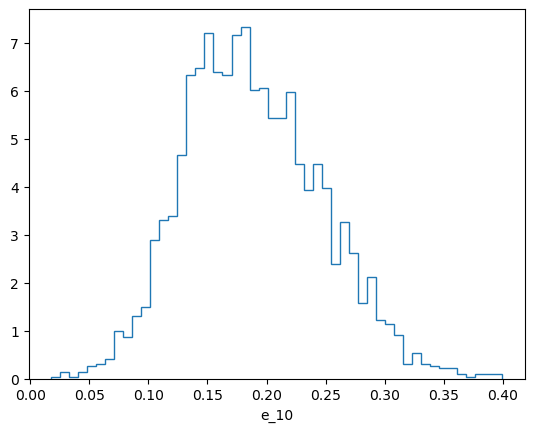

In [184]:
ecc = griddata((map_SNR, map_MA), map_e, (np.abs(likeL_samples), np.angle(likeL_samples)%(2*np.pi)), method='linear')
plt.hist(ecc, histtype='step', bins=50, density=True)
plt.xlabel('e_10')

Text(0.5, 0, 'e_10')

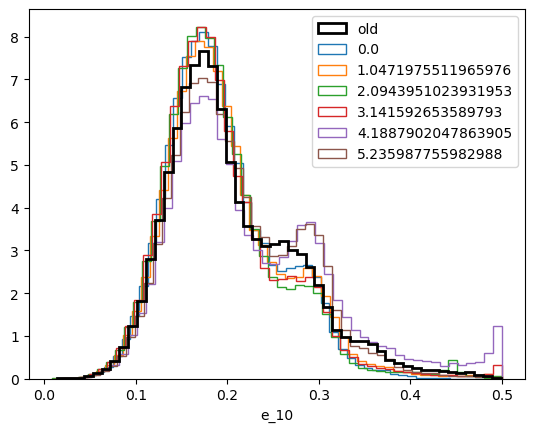

In [178]:
# Setup map
e_vals = grid_data_0['metadata']['degen_params']['ecc10']
MA_vals = grid_data_0['metadata']['MA_vals']
MA_merger = (grid_data_0['h1_phase']-grid_data_0['h0_phase']).flatten()%(2*np.pi)
SNR_tile = np.tile(grid_data_0['h1_h0'].flatten(), 3)
SNR_MA_points = (SNR_tile, np.concatenate((MA_merger-2*np.pi, MA_merger, MA_merger+2*np.pi)))
e_tile = np.tile(np.repeat(e_vals, len(MA_vals)),3)

# Rough approx of phase-agnostic method, does not flip nc or enforce prior
max_interp = interp1d(np.max(grid_data_0['h1_h0'], axis=1), e_vals, bounds_error=False)
min_interp = interp1d(np.min(grid_data_0['h1_h0'], axis=1), e_vals, bounds_error=False)
max_vals = max_interp(np.abs(samples)/np.abs(z_0))
min_vals = min_interp(np.abs(samples)/np.abs(z_0))
old_ecc = np.random.rand(len(max_vals))*(min_vals-max_vals)+max_vals
plt.hist(old_ecc, histtype='step', bins=50, label='old', density=True, color='k', lw=2, zorder=5)

# Plot for six different phase values
ecc_list = []
for MA in np.linspace(0, 2*np.pi, 6, endpoint=False):
    input_samples = (np.abs(samples)/np.abs(z_0), (np.angle(samples)-MA)%(2*np.pi))
    ecc = griddata(SNR_MA_points, e_tile, input_samples, method='linear')
    ecc[np.isnan(ecc)] = np.max(e_vals)
    ecc_list.append(ecc)
    plt.hist(ecc, histtype='step', bins=50, label=str(MA), density=True)
plt.legend()
plt.xlabel('e_10')

## Interesting plots

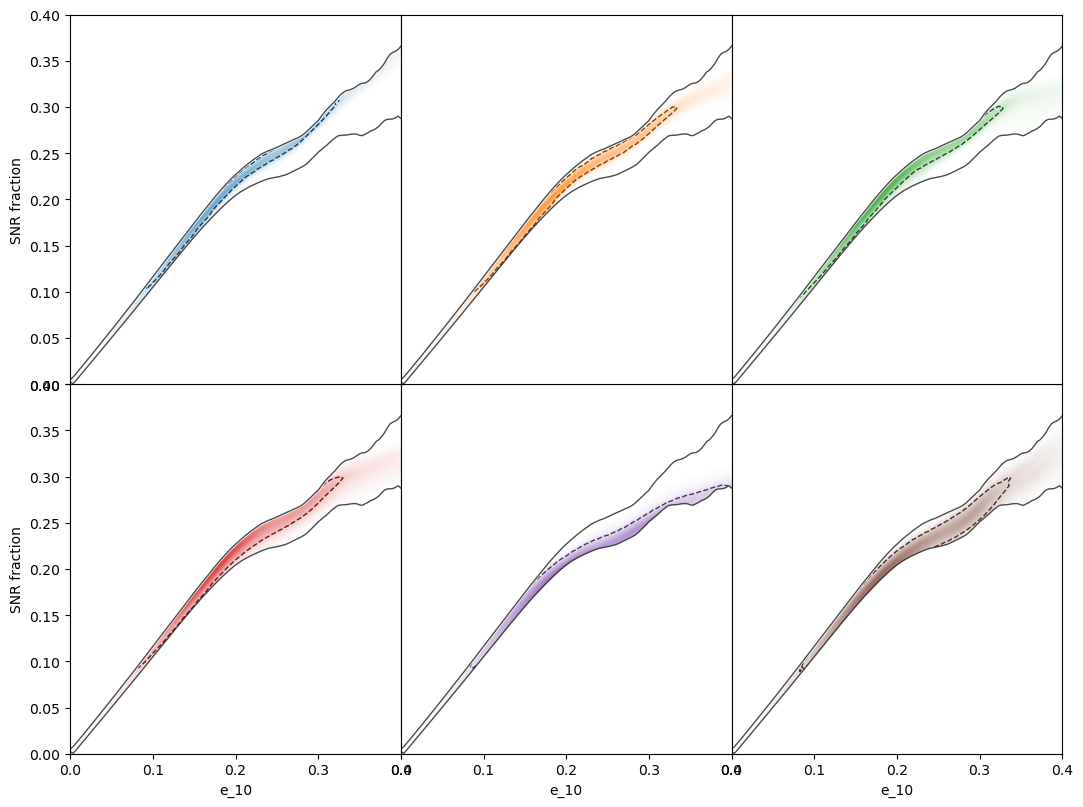

In [32]:
plt.figure(figsize=(6.4*2,4.8*2))
axs = [None]
s_xs = [1, 2, 3, 0, 0, 0]
s_ys = [0, 4, 4, 0, 1, 1]
for i in [3,4,5,0,1,2]:

    # Move onto next subplot
    plt.subplot(2,3,i+1, sharex=axs[s_xs[i]], sharey=axs[s_ys[i]])
    axs.append(plt.gca())

    # Compute kde at points on 2d grid
    kde_samples = np.array([ecc_list[i], np.abs(samples)/np.abs(z_0)])
    kernel = gaussian_kde(kde_samples)
    kde_x, kde_y = np.mgrid[np.min(ecc_list[i]):np.max(ecc_list[i]):101j, np.min(np.abs(samples)/np.abs(z_0)):np.max(np.abs(samples)/np.abs(z_0)):101j]
    max_interp = interp1d(e_vals, np.max(grid_data_0['h1_h0'], axis=1))
    min_interp = interp1d(e_vals, np.min(grid_data_0['h1_h0'], axis=1))
    inside_lines = (kde_y.flatten() <= max_interp(kde_x.flatten())*1.1)*(kde_y.flatten() >= min_interp(kde_x.flatten())*0.9)
    kde_z = np.zeros(len(kde_x.flatten()))
    kde_z[inside_lines] = kernel(np.vstack([kde_x.flatten()[inside_lines], kde_y.flatten()[inside_lines]]))
    kde_z = kde_z.reshape(kde_x.shape)
    
    # Calculate contour levels for different confidence intervals
    t = np.linspace(0, np.max(kde_z), 1000)
    integral = ((kde_z >= t[:, None, None]) * kde_z).sum(axis=(1,2))
    integral /= np.max(integral)
    f = interp1d(integral, t)
    t_contours = f([0.9])
    
    # Calculate color map with varying alpha
    c_rgba = mcolors.to_rgba(f'C{i}')
    cmap_rgbas = [c_rgba[:3]+(alpha,) for alpha in np.linspace(0,1,101)]
    cmap = mcolors.ListedColormap(cmap_rgbas)
    
    # Plot density and 90% contour
    x_coords = kde_x[:,0]
    y_coords = kde_y[0]
    dx = (x_coords[1]-x_coords[0])/2.
    dy = (y_coords[1]-y_coords[0])/2.
    extent = [x_coords[0]-dx, x_coords[-1]+dx, y_coords[0]-dy, y_coords[-1]+dy]
    plt.imshow(np.sqrt(kde_z.T), interpolation='bicubic', cmap=cmap, extent=extent, origin='lower', aspect='auto',zorder=1/4)
    contour_c = tuple(p*0.5 for p in c_rgba[:3]) +  (c_rgba[3],)
    plt.contour(kde_x, kde_y, kde_z, levels=t_contours, colors=[contour_c], linewidths=1, linestyles='dashed', zorder=2/4)
    
    # Plot min/max lines
    plt.fill_between(e_vals, np.min(grid_data_0['h1_h0']), np.min(grid_data_0['h1_h0'], axis=1), color='w', zorder=3/4)
    plt.fill_between(e_vals, np.max(grid_data_0['h1_h0'], axis=1), np.max(grid_data_0['h1_h0']), color='w', zorder=3/4)
    plt.plot(e_vals, np.max(grid_data_0['h1_h0'], axis=1), c='k', lw=1, alpha=0.7, zorder=4/4)
    plt.plot(e_vals, np.min(grid_data_0['h1_h0'], axis=1), c='k', lw=1, alpha=0.7, zorder=4/4)
    
    # Plot formatting
    if axs[s_xs[i]] is None:
        plt.xlabel('e_10')
        plt.xlim(0,0.4)
    else:
        plt.gca().axes.get_xaxis().set_visible(False)
    if axs[s_ys[i]] is None:
        plt.ylabel('SNR fraction')
        plt.ylim(0,0.4)
    else:
        plt.gca().axes.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

(0.0, 1.0)

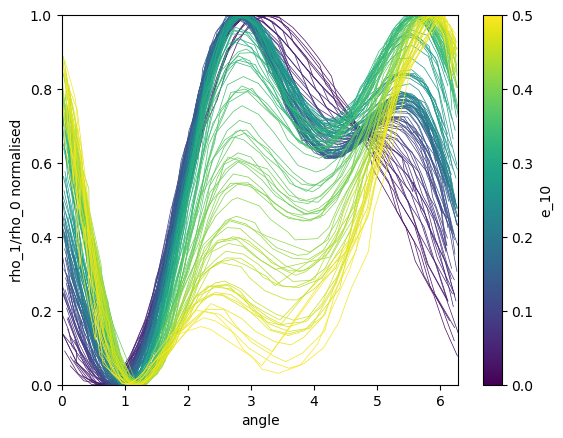

In [260]:
# Plot for each constant eccentricity
cmap = plt.cm.viridis(np.linspace(0,1,len(e_vals)))
for i in range(len(e_vals)):
    if i>5:
        x = (grid_data_0['h1_phase']-grid_data_0['h0_phase'])[i]%(2*np.pi)
        y = grid_data_0['h1_h0'][i]
        x, y = zip(*sorted(zip(x, y)))
        min_y = np.min(y)
        max_y = np.max(y)
        y = (y-min_y)/(max_y-min_y)
        plt.plot(x, y, c=cmap[i], lw=0.5)

# Fake colorbar
colors = np.linspace(np.min(e_vals),np.max(e_vals),len(e_vals))
mappable = plt.scatter([10]*len(e_vals), [10]*len(e_vals), s=1, c=colors, cmap='viridis')
plt.colorbar(mappable, label='e_10')

# Plot formatting
plt.xlabel('angle')
plt.ylabel('rho_1/rho_0 normalised')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)